In [14]:
%load_ext autoreload
from ddls.distributions.custom_skew_norm import CustomSkewNorm
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

from ddls.plotting.plotting import PlotAesthetics

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import copy

from omegaconf import OmegaConf
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# put keys in '<agent_name> _ <dist_name>' format (i.e. with a ' _ ' separator), will then parse accordingly below

agent_to_run_path = {
        
    'Ape-X DQN _ A': 'ong/ddls/30fg7pae',
    'Ape-X DQN _ B': 'ong/ddls/1z97dgaf',
    
    'SiP-ML _ A': 'ong/ddls/ojp3w9mb',
    'SiP-ML _ B': 'ong/ddls/2mfzylff',
    
}

In [16]:
%autoreload
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run

In [17]:
keys_to_ignore = ['valid/step_stats/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['valid/episode_stats/'] # for tidying up keys
agent_to_episode_stats_dict, agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_run(agent_to_run_path, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove)

# parse agent name and dist name
for _dict in [agent_to_episode_stats_dict, agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict]:
    for idx, _agent in enumerate(_dict['Agent']):
        # unpack agent and dist name
        agent, dist = _agent.split(' _ ')
        # update dict
        _dict['Agent'][idx] = agent
        _dict['Distribution'].append(dist)

# convert dicts to dataframes
print(f'\nEpisode stats:')
for key, val in agent_to_episode_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)

episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)

episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)


Recorded keys: {'valid/episode_stats/num_jobs_blocked', 'valid/episode_stats/mean_demand_compute_throughput', 'valid/episode_stats/num_jobs_completed', 'valid/episode_stats/jobs_completed_max_partitions_per_op', 'valid/episode_stats/job_completion_time', '_timestamp', 'valid/episode_stats/mean_load_rate', 'valid/episode_stats/mean_demand_dep_throughput', 'valid/episode_stats/num_jobs_arrived', 'valid/episode_stats/demand_compute_info_processed', 'valid/episode_stats/dep_info_processed', 'valid/episode_stats/jobs_completed_original_demand_total_operation_memory_cost', 'valid/episode_stats/episode_time', 'valid/episode_stats/return', 'valid/episode_stats/jobs_blocked_original_demand_num_edges', 'valid/episode_stats/jobs_completed_mean_mounted_worker_utilisation_frac', 'valid/episode_stats/jobs_blocked_original_demand_num_nodes', 'valid/episode_stats/job_computation_overhead_time', 'valid/episode_stats/jobs_blocked_job_sequential_completion_time', 'valid/episode_stats/jobs_blocked_total_

,dep_info_processed,num_jobs_arrived,blocking_rate,episode_end_time,mean_demand_total_throughput,compute_info_processed,num_jobs_blocked,mean_demand_compute_throughput,episode_time,demand_dep_info_processed,...,episode_start_time,mean_flow_throughput,demand_total_info_processed,mean_dep_throughput,cluster_info_processed,mean_compute_throughput,mean_load_rate,mean_cluster_throughput,Agent,Distribution
0,1.351642e+12,201,0.721393,200000,7.965634e+06,7.772070e+11,145,3.886035e+06,200000,8.159197e+11,...,0,4.714159e+06,1.593127e+12,6.758208e+06,2.128849e+12,3.886035e+06,3.227430e+07,1.064424e+07,Ape-X DQN,A
1,2.914989e+12,201,0.472637,200000,1.800192e+07,1.764872e+12,95,8.824359e+06,200000,1.835513e+12,...,0,1.003212e+07,3.600385e+12,1.457494e+07,4.679861e+12,8.824359e+06,3.227430e+07,2.339930e+07,Ape-X DQN,B
2,1.465055e+12,201,0.721393,200000,8.194603e+06,7.983417e+11,145,3.991709e+06,200000,8.405790e+11,...,0,5.174424e+06,1.638921e+12,7.325274e+06,2.263396e+12,3.991709e+06,3.154729e+07,1.131698e+07,SiP-ML,A
3,1.752779e+12,201,0.681592,200000,9.955944e+06,9.970368e+11,137,4.985184e+06,200000,9.941521e+11,...,0,6.522830e+06,1.991189e+12,8.763896e+06,2.749816e+12,4.985184e+06,3.117462e+07,1.374908e+07,SiP-ML,B


,jobs_completed_max_partitions_per_op,job_communication_overhead_time,jobs_completed_original_demand_num_nodes,jobs_completed_num_edges,job_computation_overhead_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_max_acceptable_job_completion_time,jobs_completed_job_sequential_completion_time,jobs_completed_original_demand_num_edges,...,jobs_completed_original_demand_total_dependency_size,job_completion_time,jobs_completed_total_dependency_size,job_completion_time_speedup,jobs_completed_total_operation_memory_cost,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_num_mounted_workers,Agent,Distribution
0,5.600000,0,94.145455,488.763636,9332.133311,0.416727,1.370404e+10,13834.391327,34315.408182,103.872727,...,1.437142e+10,9593.593688,2.389280e+10,3.849692,1.370404e+10,43.527273,0.673025,6.436364,Ape-X DQN,A
1,3.295238,0,105.619048,482.495238,11852.939246,0.545238,1.611110e+10,16939.036167,31689.620476,117.742857,...,1.675363e+10,12214.314943,2.659150e+10,2.657371,1.611110e+10,15.638095,0.755156,3.980952,Ape-X DQN,B
2,11.454545,0,92.909091,647.290909,7315.176989,0.390909,1.413658e+10,13216.948355,34962.421818,102.272727,...,1.489732e+10,7576.527473,2.593580e+10,5.308552,1.413658e+10,157.854545,0.527844,11.818182,SiP-ML,A
3,6.634921,0,99.079365,510.968254,7868.188214,0.655556,1.526528e+10,16736.637056,26593.533333,111.190476,...,1.522134e+10,8162.675533,2.683698e+10,3.409615,1.526528e+10,71.619048,0.613701,7.539683,SiP-ML,B


,jobs_blocked_original_demand_num_nodes,jobs_blocked_max_acceptable_job_completion_time,jobs_blocked_original_demand_total_dependency_size,jobs_blocked_max_acceptable_job_completion_time_frac,jobs_blocked_num_nodes,jobs_blocked_original_demand_num_edges,jobs_blocked_total_dependency_size,jobs_blocked_job_sequential_completion_time,jobs_blocked_total_operation_memory_cost,jobs_blocked_num_edges,jobs_blocked_original_demand_total_operation_memory_cost,Agent,Distribution
0,108.096552,6261.726517,1.712668e+10,0.240828,108.096552,121.482759,1.712668e+10,27261.428966,1.692515e+10,121.482759,1.692515e+10,Ape-X DQN,A
1,102.757895,11176.340753,1.594385e+10,0.429579,102.757895,115.421053,1.594385e+10,26450.994737,1.596004e+10,115.421053,1.596004e+10,Ape-X DQN,B
2,104.662069,8114.257593,1.644905e+10,0.289586,104.662069,117.110345,1.644905e+10,28587.018621,1.623145e+10,117.110345,1.623145e+10,SiP-ML,A
3,104.204380,17099.945887,1.608746e+10,0.534818,104.204380,115.978102,1.608746e+10,31548.131387,1.559118e+10,115.978102,1.559118e+10,SiP-ML,B


In [18]:


def barplot(df, metric):
    aesthetics = PlotAesthetics()
    aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

    estimator = np.mean # np.mean np.median

    scaling_factor = 1
    width_scaling_factor = 1
    height_scaling_factor = 1

    # xaxis = episode_stats_df['run_time']
    # xaxis = episode_stats_df['Distribution']
    xaxis = 'Distribution'
    xaxis_label = '$\\beta$ Distribution'

    # stat = 'count'
    # stat = 'percent'
    # stat = 'probability'

    metric_to_yaxis_label = {
        'return': 'Episode Return',
        'mean_cluster_throughput': 'Cluster Throughput (B/s)',
        'mean_demand_total_throughput': 'Demand Throughput (B/s)',
        'blocking_rate': 'Blocking Rate',
        'job_completion_time': 'JCT (s)',
    }

    hue = 'Agent'

    legend = 'auto'
    # legend = None

    orient = 'v'
    # orient = 'h'

    ylim = None
    # ylim = [20, 100]

    yaxis_label_style = 'plain' # sci plain

    # ylog = True
    ylog = False
    
    # normalise_y_vals = False
    normalise_y_vals = True
    
    
    
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    
    yaxis_label = metric_to_yaxis_label[metric]
    if orient == 'h':
        orig_xaxis = copy.copy(xaxis)
        orig_metric = copy.copy(metric)
        orig_xaxis_label = copy.copy(xaxis_label)
        orig_yaxis_label = copy.copy(yaxis_label)
        
        xaxis = orig_metric
        xaxis_label = orig_yaxis_label
        metric = orig_xaxis
        yaxis_label = orig_xaxis_label
        
    if normalise_y_vals:
        plot_df = copy.deepcopy(df)
        max_y_val = np.max(plot_df[metric])
        plot_df[metric] /= max_y_val
        yaxis_label += '\n(Normalised)'
    else:
        plot_df = df
    
    g = sns.barplot(data=plot_df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     orient=orient,
                     # legend=legend,
                     # estimator=None,
                    )
    
    if legend is not None:
        # ax.legend(labels=context_to_dist.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=4, labelspacing=0.1, columnspacing=3, prop={'size': 4})
        # sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, labelspacing=0.1, columnspacing=1, prop={'size': 5.5}, title=None, frameon=False)
        sns.move_legend(ax, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, labelspacing=0.1, columnspacing=1, prop={'size': 5.75}, title=None, frameon=False)

    if ylim is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])
    g.set_xlabel(xaxis_label)
    g.set_ylabel(yaxis_label)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    # g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric return -> min=-86 | max=24 | mean=-53.5


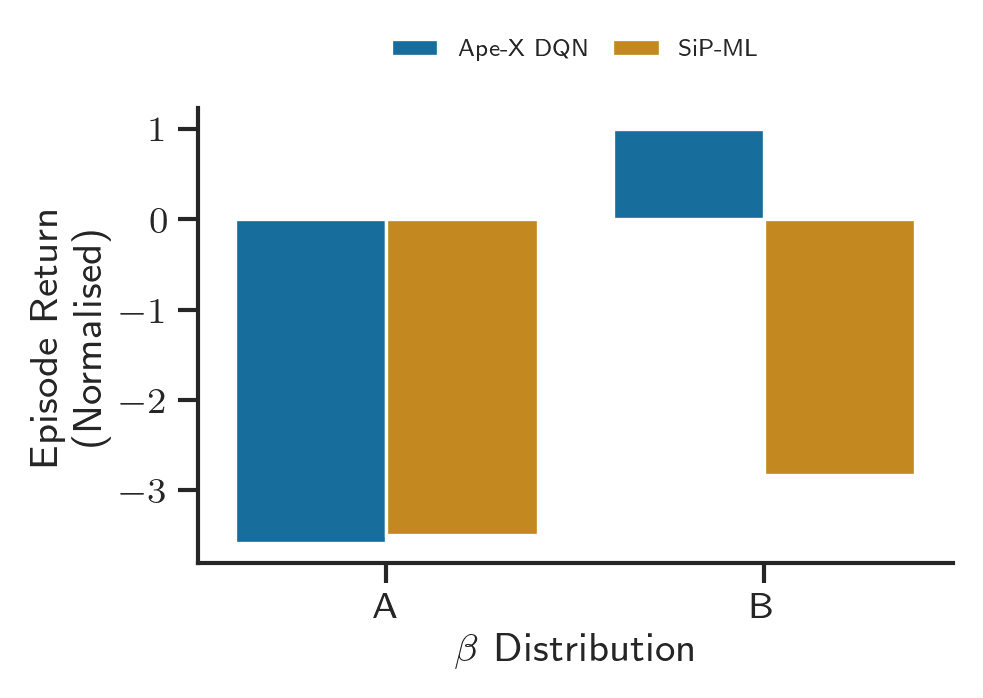

Plotting metric mean_cluster_throughput -> min=10644243.38852632 | max=23399303.170373898 | mean=14777402.152970353


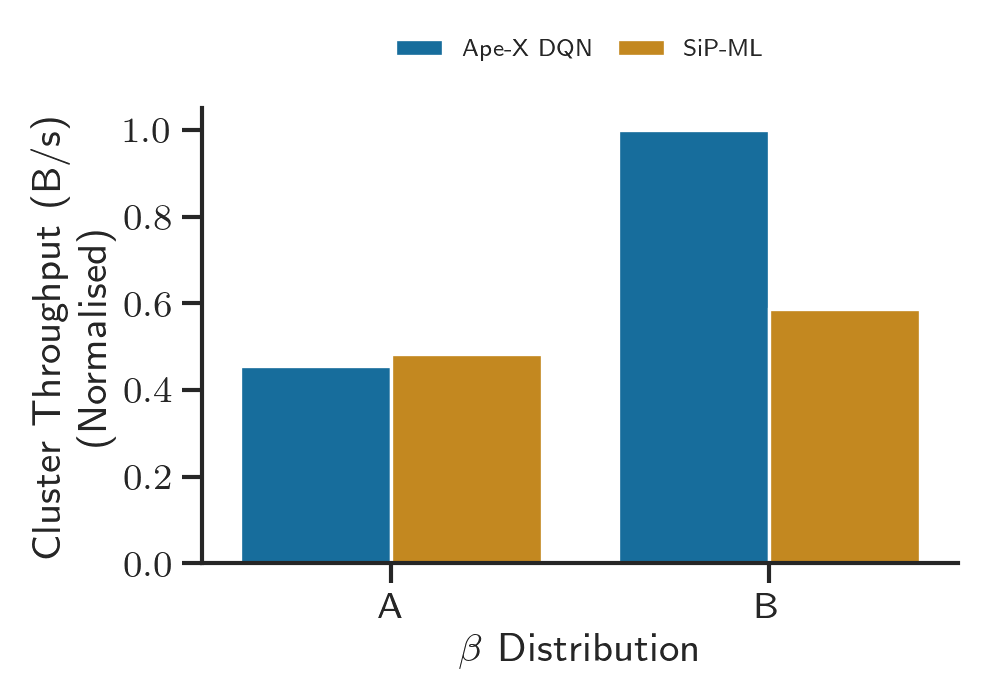

Plotting metric mean_demand_total_throughput -> min=7965633.752193734 | max=18001923.54151869 | mean=11029526.174982347


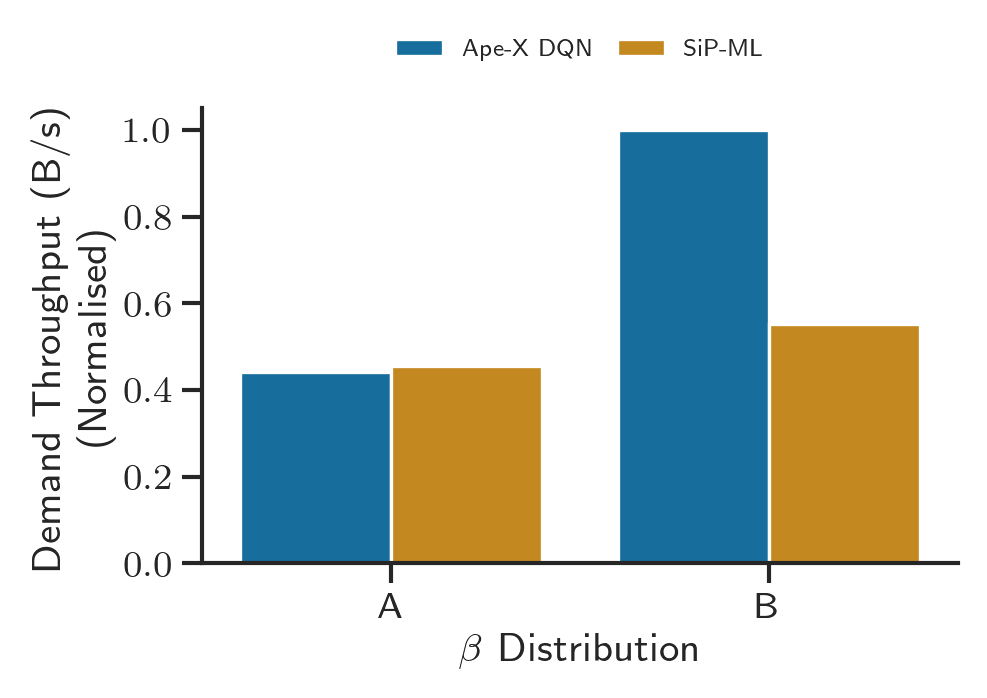

Plotting metric blocking_rate -> min=0.472636815920398 | max=0.7213930348258707 | mean=0.6492537313432837


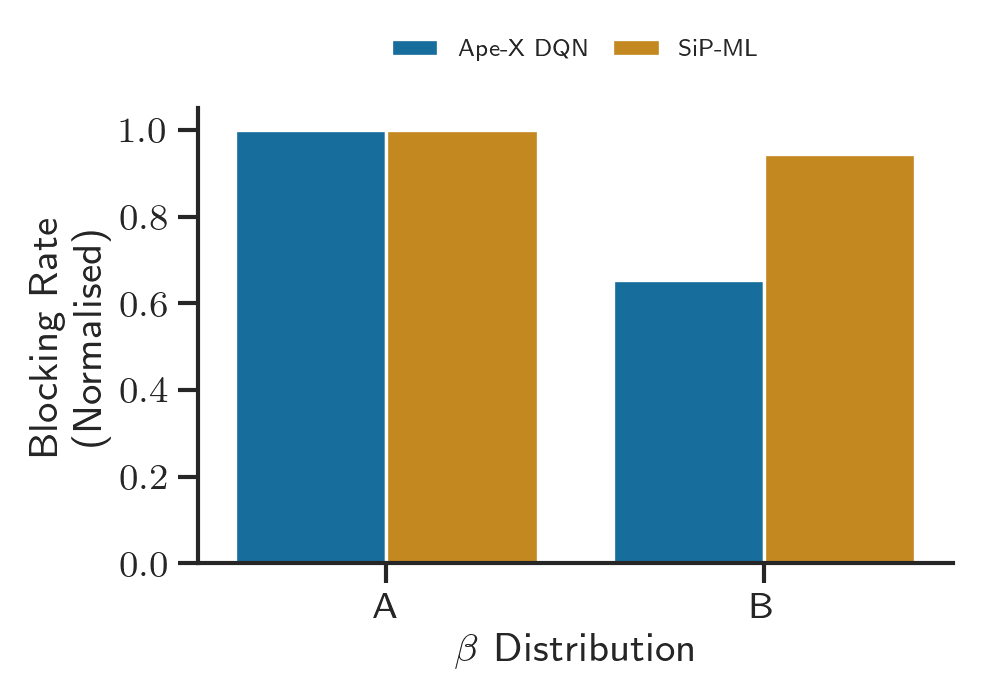

In [19]:
metrics = ['return', 'mean_cluster_throughput', 'mean_demand_total_throughput', 'blocking_rate']
for metric in metrics:
    barplot(df=episode_stats_df, metric=metric)